In [5]:
#import modules
import numpy as np
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
#import files
import sys
sys.path.append('..')
from utils import matrix as mt
from utils import vamp

This notebook demonstrates Vector Approximate Message Passing in the setup of **Sparse Linear Regression**.  (Environment : Python 3.11.2)

### Setup
Sparse Linear Regression refers to the problem of recovering a sparse vector $\boldsymbol{x} \in \mathbb{C}^N$ from linear observation $\boldsymbol{y} = A\boldsymbol{x} + \boldsymbol{w}$, where $A \in \mathbb{C}^{M \times N}$ is the sensing matrix and $\boldsymbol{w}$ is Additive White Gaussian Noise (AWGN) with variance $\gamma_w^{-1}$.
Exploitation of the sparsity allows us to recover $\boldsymbol{x}$ even when the sampling ratio $M/N < 1$.  

We assume i.i.d. Bernoulli-Gaussian prior for each component of $\boldsymbol{x}$ :   
$x_i \sim p_{\text{in}}(x_i) = \rho \mathcal{N}(x_i ; 0,1) + (1-\rho) \delta (x_i) \ \ \ (i = 1,...,N)$  
where $\mathcal{N}(x ; m,v)$ is the circular complex gaussian density, and $0 < \rho < 1$. The prior for $\boldsymbol{x}$ is $p_{\text{in}}(\boldsymbol{x}) = \prod_i^{N} p_{\text{in}}(x_i)$.  
The likelihood function is given as  
$p_{\text{out}}(\boldsymbol{y} | \boldsymbol{x}) = \mathcal{N}( \boldsymbol{y}; A\boldsymbol{x}, \gamma_w^{-1} I_M)$  
The Bayes rule is stated as  
$p(\boldsymbol{x} | \boldsymbol{y}) \propto p_{\text{in}}(\boldsymbol{x}) p_{\text{out}}(\boldsymbol{y} | \boldsymbol{x})$

In [6]:
#genearte sparse vector x and observation y, given sensing matrix A, sparsity rho and noise precision gamma_w
def sparse_data_generation(A, rho, gamma_w):
    M = len(A)
    N = len(A[0])
    x = mt.complex_sparse_vector(N, 1, rho)
    y = A@x + mt.complex_gaussian_vector(M, 1/gamma_w)
    return x, y

### Numerical experiment with i.i.d. Gaussian $A$  
Here, we test the performance of VAMP in the case where each entry of $A$ is i.i.d. drawn from $\mathcal{N}(0, 1/N)$.   
In the numerical experiment, we use $N = 1000$, and  $\alpha\ (=\frac{M}{N}) \ = 0.3$. The sparsity and noise precision is set as $\rho = 0.1$ and $\gamma_w = 10^4$, both of which are estimated by EM algorithm.

Estimated sparsity :  0.09725594765512399
Estimated noise variance :  0.00011833616498812344


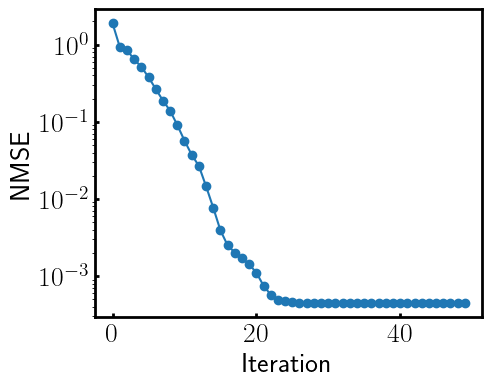

In [7]:
#data setting
N = 1024
alpha = 0.3
M = int(N*alpha)
rho = 0.1
gamma_w = 1e4

#data generation
A = mt.complex_gaussian_matrix(M, N, 1/N) #sensing matrix with i.i.d. gaussian entries
x, y = sparse_data_generation(A, rho, gamma_w)

#algorithmic condition
EM = True
damping = 1
Kit = 50
rho_init = 0.5 #initial value of EM
gamma_w_init = 1 #initial value of EM

#VAMP
error, rho_EM, gamma_w_EM = vamp.SLR_VAMP(x, y, A, rho_init, gamma_w_init, damping, EM, Kit)

#show results
fig, ax = plt.subplots(1,1, figsize=(5, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error, marker = "o")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_yscale('log')
print("Estimated sparsity : ", rho_EM)
print("Estimated noise variance : ", 1/gamma_w_EM)

### Application to Fourier measurement

We consider a measurement process where the 2-D Discrete Fourier transform of $\bm{x} \in \mathbb{C}^N$ is subsampled. The corresponding sensing matrix is written as  
$A = S F$  
in which $F \in \mathbb{C}^{N \times N}$ is the 2-D DFT and $S \in \{0,1\}^{M, N}$ is the "selection matrix" which consists of $M$ row vectors of N-dimensional identity matrix $I_N$.  
Since $A^H A = F^H M F$ with $M = \text{Diag}(\bm{m})\ (\bm{m} \in \{0,1\}^N)$, the LLMSE estimation in VAMP iteration has a fast implementation using FFT.

Estimated sparsity :  0.0959951682208625
Estimated noise variance :  0.0011239600629104288


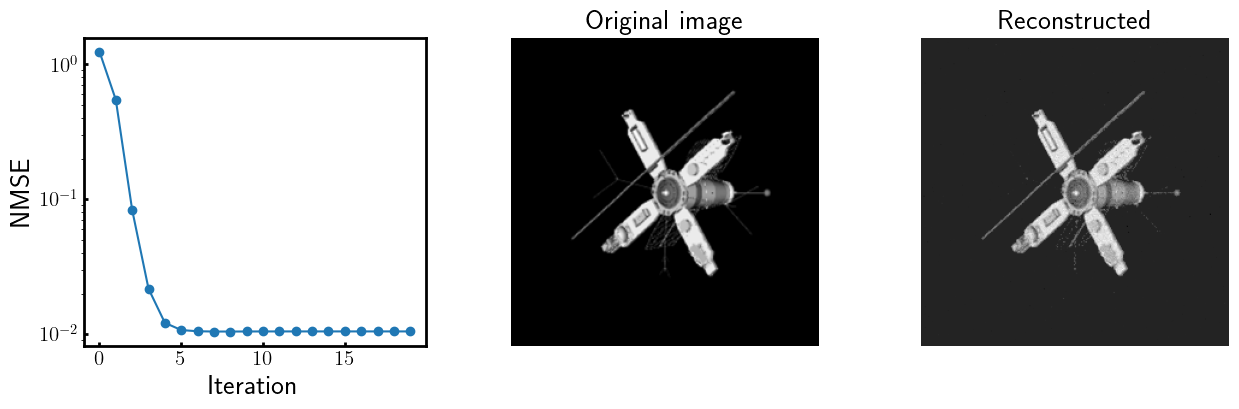

In [11]:
# data generation
def fourier_measurement(x, gamma_w, alpha):
    # x is (n,n) 2-d array, 0 < alpha < 1 is the sampling ratio
    n = len(x)
    mask = mt.mask_vector_2d(n, alpha)
    y = mask*(fft2(x)/n + mt.complex_gaussian_matrix(n, n, 1/gamma_w)) # unobserved fourier coefficients are multiplied by zero
    return y, mask # output y corresponds to (S^H y) in the notation above.

#load image
image = cv2.imread('../data/satellite.png', 0) #256*256 pixels
x = image.astype('float')/256 # x is [0,1]-valued 

#fourier measurement
gamma_w = 1e3 # noise precision
alpha = 0.5 # sampling ratio
y, mask = fourier_measurement(x, gamma_w, alpha)

#run VAMP
EM = True
Kit = 20
damping = 0.95
rho_init = 0.5 # initial value for the EM estimation of rho
gamma_w_init = 1.0 # initial value for the EM estimation of gamma_w
x_vamp, error, rho_EM, gamma_w_EM = vamp.SLM_fourier_VAMP(x, y, mask, rho, gamma_w, damping, EM, Kit)

#show results
fig, ax = plt.subplots(1,3, figsize=(15, 4))
ax[0].tick_params(direction="in", length=3, width=2, labelsize=15)
ax[0].spines["right"].set_linewidth(2)
ax[0].spines["left"].set_linewidth(2)
ax[0].spines["top"].set_linewidth(2)
ax[0].spines["bottom"].set_linewidth(2)
ax[0].plot(error, marker = "o")
ax[0].set_xlabel("Iteration", fontsize = 20)
ax[0].set_ylabel("NMSE", fontsize = 20)
ax[0].set_yscale('log')
ax[1].axis("off")
ax[1].set_title("Original image", fontsize = 20)
ax[1].imshow(np.real(x),cmap = "gray")
ax[2].axis("off")
ax[2].set_title("Reconstructed", fontsize = 20)
ax[2].imshow(np.real(x_vamp), cmap = "gray")
print("Estimated sparsity : ", rho_EM)
print("Estimated noise variance : ", 1/gamma_w_EM)

### References  
- **derivation of VAMP**   
S. Rangan, P. Schniter and A. K. Fletcher, "Vector Approximate Message Passing," in IEEE Transactions on Information Theory (2019)  
- **EM-VAMP**  
A. K. Fletcher and P. Schniter, "Learning and free energies for vector approximate message passing," 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)  
- **EM learning for Gaussian-Bernoulli prior**  
J. Vila and P. Schniter, "Expectation-maximization Bernoulli-Gaussian approximate message passing," 2011 Conference Record of the Forty Fifth Asilomar Conference on Signals, Systems and Computers (ASILOMAR)  
- **Damping of VAMP**  
S. Sarkar, R. Ahmad and P. Schniter, "MRI Image Recovery using Damped Denoising Vector AMP," ICASSP 2021 - 2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)
